In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from collections import deque

from sklearn.metrics import root_mean_squared_error as RMSE

import sys
import os

root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root_dir not in sys.path:
    sys.path.append(root_dir)

from utils.data_loaders import cv_splits_loader
from utils.data_loaders import test_dataset_loader
from utils.plotter import plot_pred
from utils.evaluator import model_eval

from n2o_models.naive import NaivePersistence, NaiveRollingMean

In [62]:
train_df, val_df = cv_splits_loader(split = 1)

In [63]:
train_df.columns

Index(['N2O', 'NH4', 'NO3', 'N2O_lag1', 'N2O_lag2', 'N2O_lag3', 'N2O_lag4',
       'N2O_lag5', 'N2O_lag6', 'N2O_lag7', 'N2O_lag8', 'N2O_lag9', 'N2O_lag10',
       'N2O_lag11', 'N2O_lag12', 'N2O_lag13', 'N2O_lag14', 'N2O_lag15',
       'N2O_lag16', 'N2O_lag17', 'N2O_lag18', 'N2O_lag19', 'N2O_lag20',
       'NH4_lag1', 'NH4_lag2', 'NH4_lag3', 'NH4_lag4', 'NH4_lag5', 'NH4_lag6',
       'NH4_lag7', 'NH4_lag8', 'NH4_lag9', 'NH4_lag10', 'NH4_lag11',
       'NH4_lag12', 'NH4_lag13', 'NH4_lag14', 'NH4_lag15', 'NH4_lag16',
       'NH4_lag17', 'NH4_lag18', 'NH4_lag19', 'NH4_lag20', 'NO3_lag1',
       'NO3_lag2', 'NO3_lag3', 'NO3_lag4', 'NO3_lag5', 'NO3_lag6', 'NO3_lag7',
       'NO3_lag8', 'NO3_lag9', 'NO3_lag10', 'NO3_lag11', 'NO3_lag12',
       'NO3_lag13', 'NO3_lag14', 'NO3_lag15', 'NO3_lag16', 'NO3_lag17',
       'NO3_lag18', 'NO3_lag19', 'NO3_lag20', 'N2O_lead1', 'N2O_lead2'],
      dtype='object')

In [66]:
train_df.head()

,N2O,NH4,NO3,N2O_lag1,N2O_lag2,N2O_lag3,N2O_lag4,N2O_lag5,N2O_lag6,N2O_lag7,...,NO3_lag13,NO3_lag14,NO3_lag15,NO3_lag16,NO3_lag17,NO3_lag18,NO3_lag19,NO3_lag20,N2O_lead1,N2O_lead2
time,,,,,,,,,,,,,,,,,,,,,
2022-06-12 02:20:00,0.459780,0.802299,1.563254,0.383073,0.268895,0.217766,0.163310,0.102662,0.037095,0.016088,...,1.418028,1.182717,0.912930,0.482552,0.123406,0.005908,0.018822,0.061391,0.532986,0.535417
2022-06-12 02:30:00,0.532986,1.036766,1.079640,0.459780,0.383073,0.268895,0.217766,0.163310,0.102662,0.037095,...,1.048384,1.418028,1.182717,0.912930,0.482552,0.123406,0.005908,0.018822,0.535417,0.449248
2022-06-12 02:40:00,0.535417,0.946469,0.694841,0.532986,0.459780,0.383073,0.268895,0.217766,0.163310,0.102662,...,0.496807,1.048384,1.418028,1.182717,0.912930,0.482552,0.123406,0.005908,0.449248,0.205990
2022-06-12 02:50:00,0.449248,1.065319,0.313555,0.535417,0.532986,0.459780,0.383073,0.268895,0.217766,0.163310,...,0.081347,0.496807,1.048384,1.418028,1.182717,0.912930,0.482552,0.123406,0.205990,0.006684
2022-06-12 03:00:00,0.205990,1.901509,0.048804,0.449248,0.535417,0.532986,0.459780,0.383073,0.268895,0.217766,...,0.005481,0.081347,0.496807,1.048384,1.418028,1.182717,0.912930,0.482552,0.006684,0.005411


# Modelling Setup

The goal is to take upto 200 minutes of measurement of tank variables, and predict the next 30 minutes of the N2O concentration.



## Naive Persistence Model

The predicted values of N2O concentration for the next 30 minutes are all equal to the last observed value. The following plot shows an example of the persistence model's predictions.

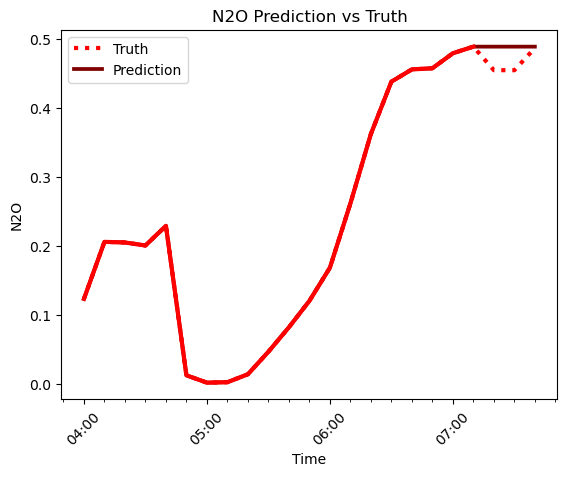

In [77]:
naive = NaivePersistence()
dp = train_df.iloc[[30]]

plot_pred(naive, dp)

## Naive Rolling Mean Model

The predicted values of N2O concentration in 10 minutes is the mean of the last `n` observed values. This rolling mean is then iteratively calculated for the next 2 values, giving the predicted N2O concentration for the next 30 minutes.

The window size `n`, the number of past values to include in the mean, is a hyperparameter. It can be tuned to find the best possible window size.

The following plot shows an example of a rolling mean model prediction with window size `n = 4`.

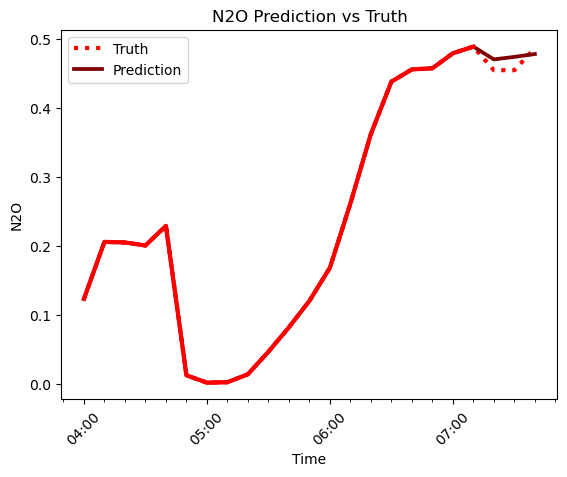

In [12]:
naive = NaiveRollingMean(4)
dp = train_df.iloc[[30]]

plot_pred(naive, dp)

The following plot shows an example of a rolling mean model prediction with window size `n = 15`.

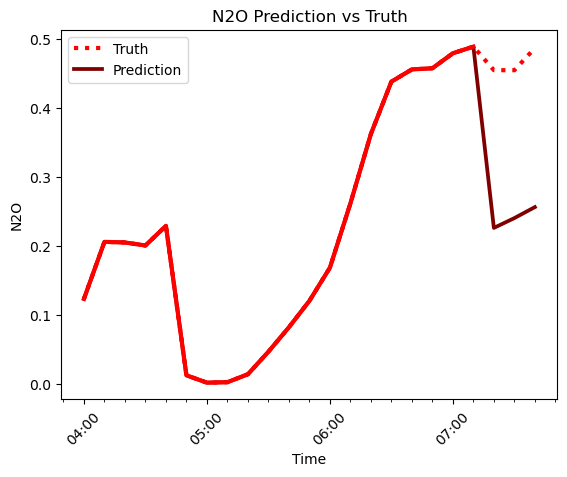

In [15]:
naive = NaiveRollingMean(15)
dp = train_df.iloc[[30]]

plot_pred(naive, dp)

In order to assess model performance, I use the root mean squared error (RMSE) metric. These two naive models will form the baseline model predictions, which I seek to improve on. Though there is no model training for these models, I have given their errors on training and validation sets below, for consistency. The naive rolling mean model error is given for each window size between 2 and 20, to compare and find the best window size.

In [26]:
naive_p = NaivePersistence()

persistence_train_error, persistence_val_error = model_eval(naive_p)

persistence_train_error = np.mean(persistence_train_error)
persistence_val_error = np.mean(persistence_val_error)

naive_rm_train_errors = []
naive_rm_val_errors = []

for window_size in range(2, 21):
    naive_rm = NaiveRollingMean(window_size = window_size)

    naive_rm_train_error, naive_rm_val_error = model_eval(naive_rm)
    naive_rm_train_errors.append(np.mean(naive_rm_train_error))
    naive_rm_val_errors.append(np.mean(naive_rm_val_error))


In [48]:
print(persistence_val_error*1e6)

print(np.array(naive_rm_val_errors)*1e6)

5.0009578594455455
[5.34765667 5.66499429 5.97252838 6.20939799 6.37761961 6.50075598
 6.60426577 6.70193499 6.79805035 6.89292356 6.98752402 7.08336434
 7.18205034 7.28522012 7.39363498 7.50588902 7.61828582 7.72844626
 7.83528483]
